In [1]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/Colab Notebooks/mecab")

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
ratings_data = pd.read_table('../ratings.txt')
ratings_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [4]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


# 1. 한국어 토크나이저 사용X. split으로

In [ ]:
# 전처리---------------------------------------------
ratings_data['document'] = ratings_data['document'].str.replace(r'[^\w]', ' ')
ratings_data['document'] = ratings_data['document'].replace('', np.nan)
ratings_data = ratings_data.dropna(how='any', axis=0)
print("# preprocessing done")


# 토크나이즈-----------------------------------------
docu_train, docu_test, y_train, y_test = train_test_split(ratings_data['document'], ratings_data['label'], shuffle=False)
print("# split done")

X_train = []
for stc in docu_train:
    X_train.append(stc.split())
  
X_test = []
for stc in docu_test:
    X_test.append(stc.split())

print("# tokenization done")

# 정수 인코딩----------------------------------------
tokenizer = Tokenizer(20000) # 단어 개수
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print("# int_encoding done")

# preprocessing done
# split done
# tokenization done
# int_encoding done


In [ ]:
# padding---------------------------------------------
max_len = max([len(x) for x in X_train]) # < 50
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print("# padding done")

# padding done


In [ ]:
# 모델 생성-------------------------------------------

model = Sequential()
# 단어 임베딩 -> 5000개의 단어를 120차원으로 내보내겠다(정수 -> 120 dimension vector)
model.add(Embedding(20000, 120))
# LSTM
model.add(LSTM(120))
# 이진 분류(sigmoid)
model.add(Dense(1, activation='sigmoid'))
#------------------------------------------------------

In [ ]:
# 모델 성능 향상---------------------------------------

# validation loss를 계속 보다가 5회 이상 loss가 증가하면, 과적합될 수 있으므로 학습을 조기 종료하겠다.
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# epoch를 반복하면서, 가장 검증데이터 정확도가 높았던 순간을 체크포인트(the_best.h5)로 저장
# 정확도가 낮아지면 모델 버려라
model_check = ModelCheckpoint('the_best_korean_split.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
%%time
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[early_stop, model_check])

Epoch 1/10
2344/2344 [==============================] - ETA: 0s - loss: 0.3938 - acc: 0.8181
Epoch 00001: val_acc improved from -inf to 0.67121, saving model to the_best.h5
2344/2344 [==============================] - 303s 129ms/step - loss: 0.3938 - acc: 0.8181 - val_loss: 0.6448 - val_acc: 0.6712
Epoch 2/10
2344/2344 [==============================] - ETA: 0s - loss: 0.3113 - acc: 0.8597
Epoch 00002: val_acc improved from 0.67121 to 0.68067, saving model to the_best.h5
2344/2344 [==============================] - 297s 127ms/step - loss: 0.3113 - acc: 0.8597 - val_loss: 0.5702 - val_acc: 0.6807
Epoch 3/10
2344/2344 [==============================] - ETA: 0s - loss: 0.2660 - acc: 0.8803
Epoch 00003: val_acc did not improve from 0.68067
2344/2344 [==============================] - 299s 127ms/step - loss: 0.2660 - acc: 0.8803 - val_loss: 0.6672 - val_acc: 0.6739
Epoch 4/10
2344/2344 [==============================] - ETA: 0s - loss: 0.2254 - acc: 0.8973
Epoch 00004: val_acc did not impro

In [ ]:
# 정확도 측정
print(model.evaluate(X_test, y_test)) # [loss, acc]

1563/1563 [==============================] - 24s 16ms/step - loss: 1.1185 - acc: 0.6772
[1.1184991598129272, 0.6771670579910278]


# 2. 한국어 tokenizer 사용 

In [5]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 3.8MB 46.3MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [6]:
from konlpy.tag import Okt

In [8]:
ratings_data = pd.read_table('../ratings.txt')
ratings_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [11]:
# 전처리---------------------------------------------
ratings_data['document'] = ratings_data['document'].str.replace(r'[^\w]', ' ')
ratings_data['document'] = ratings_data['document'].replace('', np.nan)
ratings_data = ratings_data.dropna(how='any', axis=0)
print("# preprocessing done")


# Tokenization---------------------------------------
docu_train, docu_test, y_train, y_test = train_test_split(ratings_data['document'], ratings_data['label'], shuffle=False)
print('# split done')

okt = Okt()
stopwords = ['은', '는', '이', '가', '을', '를', '에게', '에', '께', '것', '이다', '하다', '한다', '의', '으로', '로']

X_train = []
for stc in docu_train:
    words = okt.morphs(stc)
    for word in words:
        if word in stopwords:
            words.remove(word)
    X_train.append(words)

X_test = []
for stc in docu_test:
    words = okt.morphs(stc)
    for word in words:
        if word in stopwords:
            words.remove(word)
    X_test.append(words)
print("# tokenization done")

# 정수 인코딩------------------------------------------
tokenizer = Tokenizer(20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print('# int_encoding done')


# padding----------------------------------------------
max_len = max([len(x) for x in X_train])
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print("# padding done")



# 모델 생성--------------------------------------------
model = Sequential()
model.add(Embedding(20000, 120, input_length = max_len))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))

# 모델 성능 향상---------------------------------------

# validation loss를 계속 보다가 5회 이상 loss가 증가하면, 과적합될 수 있으므로 학습을 조기 종료하겠다.
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# epoch를 반복하면서, 가장 검증데이터 정확도가 높았던 순간을 체크포인트(the_best.h5)로 저장
# 정확도가 낮아지면 모델 버려라
model_check = ModelCheckpoint('the_best_korean_okt_tokenizer.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 훈련--------------------------------------------
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=64, callbacks=[early_stop, model_check] )

# 모델 평가--------------------------------------------
print(model.evaluate(X_test, y_test)) # [loss, acc]

Epoch 1/10
2344/2344 [==============================] - ETA: 0s - loss: 0.3455 - acc: 0.8464
Epoch 00001: val_acc improved from -inf to 0.76335, saving model to the_best_korean_okt_tokenizer.h5
2344/2344 [==============================] - 450s 192ms/step - loss: 0.3455 - acc: 0.8464 - val_loss: 0.5080 - val_acc: 0.7634
Epoch 2/10
2344/2344 [==============================] - ETA: 0s - loss: 0.2560 - acc: 0.8909
Epoch 00002: val_acc did not improve from 0.76335
2344/2344 [==============================] - 405s 173ms/step - loss: 0.2560 - acc: 0.8909 - val_loss: 0.5888 - val_acc: 0.7327
Epoch 3/10
2344/2344 [==============================] - ETA: 0s - loss: 0.2085 - acc: 0.9127
Epoch 00003: val_acc improved from 0.76335 to 0.78593, saving model to the_best_korean_okt_tokenizer.h5
2344/2344 [==============================] - 407s 173ms/step - loss: 0.2085 - acc: 0.9127 - val_loss: 0.4927 - val_acc: 0.7859
Epoch 4/10
2344/2344 [==============================] - ETA: 0s - loss: 0.1661 - acc:

# 해석

방법1) split로 토크나이즈한 감성 분석 → [loss, accuracy] = [1.1184991598129272, 0.6771670579910278]

방법2) okt를 이용한 형태소로 토크나이즈한 감성 분석 → [loss, accuracy] = [1.1601521968841553, 0.75825035572052]


- accuracy를 보면 2번째, 형태소를 이용한 감성 분석의 결과가 더 좋다.
- 그런데 왜 loss는 split을 한 쪽이 더 작을까?
  - case1> split을 이용한 경우, 결과값(확률)이 0.5 근처에 있다.
  - case2> 형태소를 이용한 경우, 결과값이 0 or 1 쪽으로 치우쳐 있다.<br>
  => 시각화를 통해 확인하자

In [13]:
model_split = load_model('the_best.h5')

In [16]:
split_pred = model_split.predict(X_test)
okt_pred = model.predict(X_test)

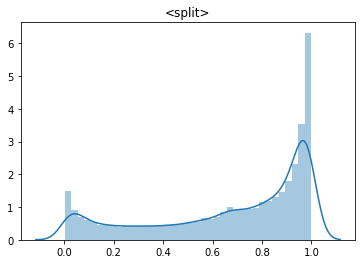

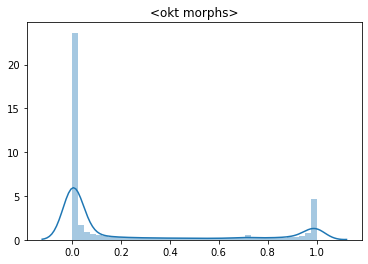

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots()
ax1 = sns.distplot(split_pred.flatten(), kde=True)
ax1.set_title("<split>")

plt.subplots()
ax2 = sns.distplot(okt_pred.flatten(), kde=True)
ax2.set_title("<okt morphs>");

(density임에도 불구하고, y축이 1보다 크게 나오는 이유는 그래프 아래쪽 넓이의 합을 1로 맞추기 위함이다. x축의 범위가 작은 경우에 이런 식으로 나타나는데, 그래프 모양은 맞는 것이므로 해석에는 지장이 없다.)

아무튼, 예상했던 대로 형태소를 이용한 감성 분석의 경우가 극단적인 값으로 치우쳐있음을 알 수 있다. 또한, split으로 나눈 경우는 상대적으로 0.5 근처의 값이 많이 나타나는 것을 확인할 수 있다.